In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pytorch_msssim import ssim
from torchvision.transforms import InterpolationMode
from models import BasicSRModel
from dataset import SRDataset

import yaml
import argparse
import warnings
import matplotlib.pyplot as plt

In [2]:
def plot(high_res, low_res, high_res_pred, high_res_pred_cubic, high_res_pred_near):
    for i in range(high_res.shape[0]):
        f = plt.figure(figsize=(20,6))
        ax1 = f.add_subplot(151)
        ax2 = f.add_subplot(152)
        ax3 = f.add_subplot(153)
        ax4 = f.add_subplot(154)
        ax5 = f.add_subplot(155)
        ax1.title.set_text('Ground truth')
        ax2.title.set_text('Downscaled image')
        ax3.title.set_text('Network output')
        ax4.title.set_text('Bicubic interpolation result')
        ax5.title.set_text('Nearest neighbor interpolation result')
        ax1.imshow(torch.swapaxes(torch.swapaxes(high_res[i], 0, 2), 0, 1)) 
        ax2.imshow(torch.swapaxes(torch.swapaxes(low_res[i], 0, 2), 0, 1))
        ax3.imshow(torch.swapaxes(torch.swapaxes(high_res_pred[i], 0, 2), 0, 1)) 
        ax4.imshow(torch.swapaxes(torch.swapaxes(high_res_pred_cubic[i], 0, 2), 0, 1))
        ax5.imshow(torch.swapaxes(torch.swapaxes(high_res_pred_near[i], 0, 2), 0, 1))

In [3]:
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

with open('../configs/baseline.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
test_path = config['Dataset']['test_path']
if config['Eval']['interpolation'] == 'bilinear':
    interpolation_mode = InterpolationMode.BILINEAR
elif config['Eval']['interpolation'] == 'bicubic':
    interpolation_mode = InterpolationMode.BICUBIC
elif config['Eval']['interpolation'] == 'nearest-neighbors':
    interpolation_mode = InterpolationMode.NEAREST

test_dataset = SRDataset(test_path, image_size=config['Dataset']['image_size'], upscale_factor=config['upscale_factor'], jitter_val=config['Dataset']['jitter_val'], interpolation=InterpolationMode.BILINEAR, mode = 'Test_both')

eval_dataloader = DataLoader(
    test_dataset,
    batch_size=config['Dataset']['batch_size'],
    shuffle=config['Dataset']['shuffle'],
    num_workers=0 if device == 'cpu' else 2,
    drop_last=config['Dataset']['drop_last'],
    pin_memory=config['Dataset']['pin_memory'],
)

print(f" * Testing dataset contains {len(test_dataset)} image(s).")

model = BasicSRModel(upscale_factor = config['upscale_factor'], layers = config['Model']['layers'], residual=config['Model']['residual']).to(device)
save_dir = config['Eval']['save_dir']
learning_rate = config['Train']['lr']
model.load_state_dict(torch.load(('{:s}/model'.format(save_dir) + ('_res' if config['Model']['residual'] else '') + '_best_lr_{:.0E}.pth'.format(learning_rate)), map_location=torch.device(device)))
mse = nn.MSELoss()


Using cpu device
 * Testing dataset contains 10 image(s).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Evaluation PSNR (bilinear): 25.607750
Evaluation SSIM (bilinear): 0.855855
Evaluation PSNR (bicubic): 24.555355
Evaluation SSIM (bicubic): 0.846623
Evaluation PSNR (nearest): 21.282261
Evaluation SSIM (nearest): 0.731434


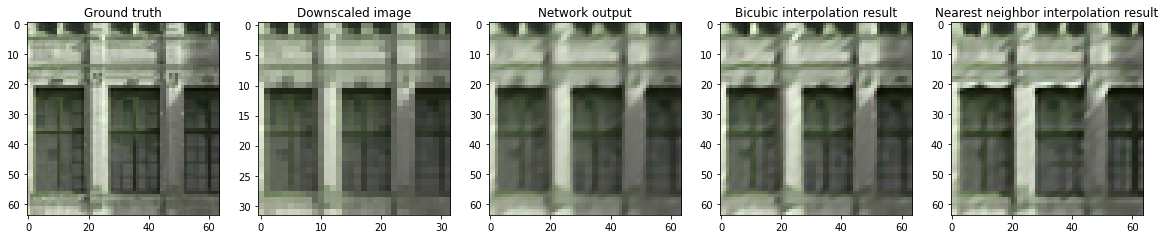

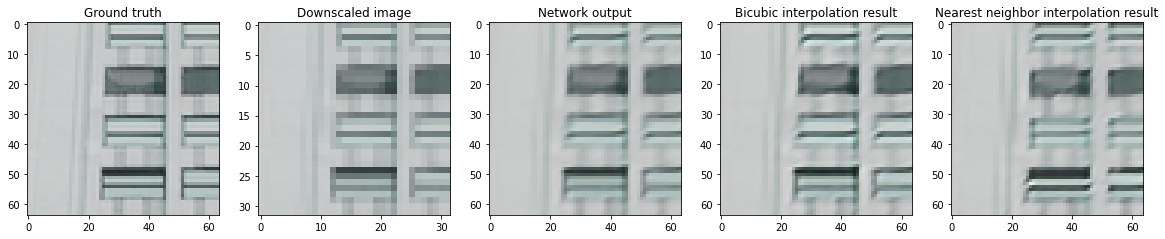

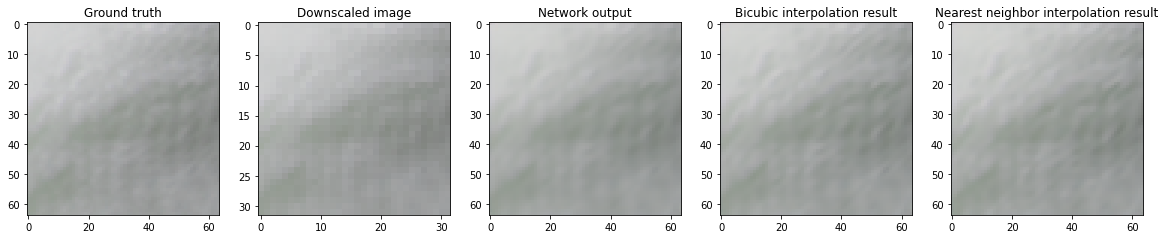

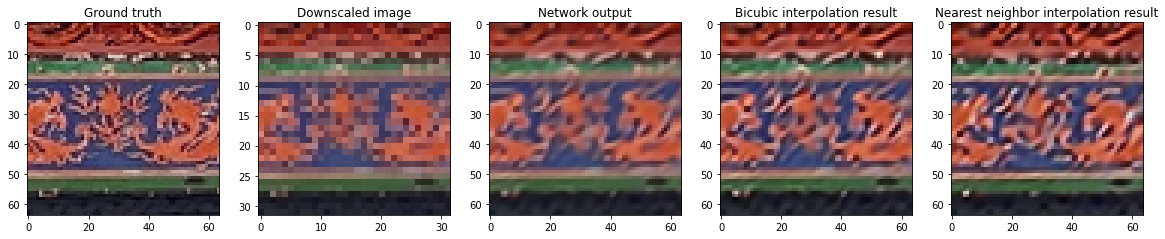

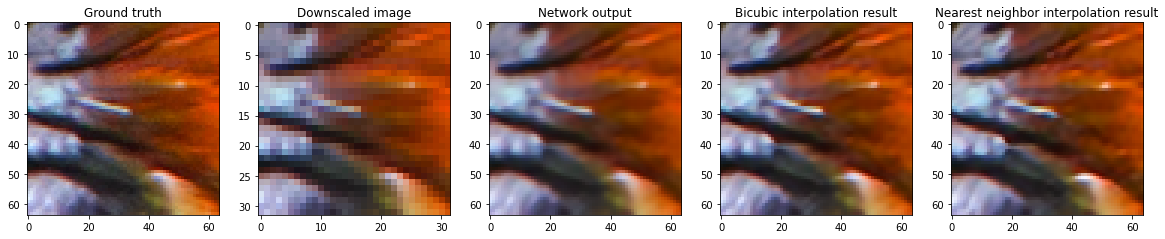

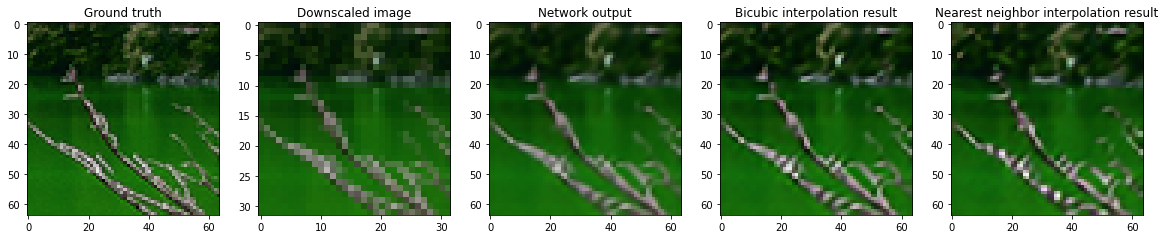

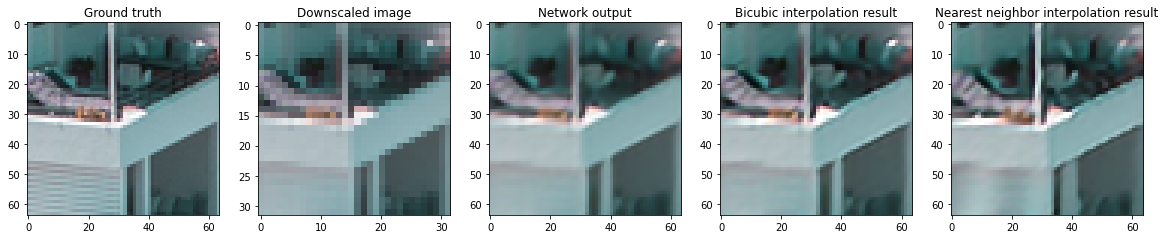

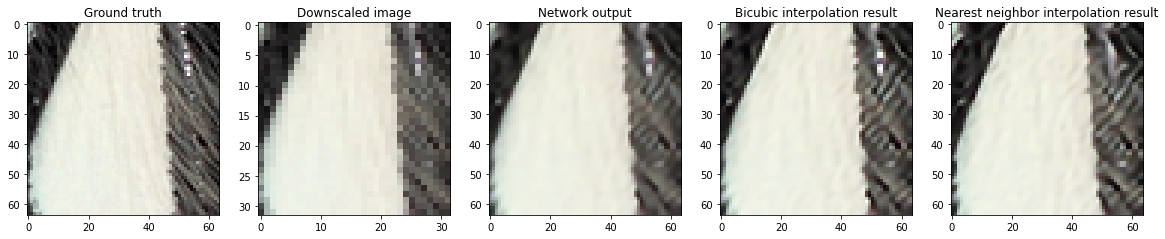

In [4]:
cnt = 0
psnr = 0
SSIM = 0
psnr_cubic = 0
SSIM_cubic = 0
psnr_near = 0
SSIM_near = 0
for batch_id, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        low_res, low_res_cubic, low_res_near, high_res = batch
        low_res = low_res.to(device)
        low_res_cubic = low_res_cubic.to(device)
        low_res_near = low_res_near.to(device)
        high_res = high_res.to(device)
        high_res_prediction = model(low_res)
        high_res_prediction_cubic = model(low_res_cubic)
        high_res_prediction_near = model(low_res_near)
        plot(high_res, low_res, high_res_prediction, high_res_prediction_cubic, high_res_prediction_near)
        psnr += -10*torch.log10(mse(high_res_prediction, high_res))
        psnr_cubic += -10*torch.log10(mse(high_res_prediction_cubic, high_res))
        psnr_near += -10*torch.log10(mse(high_res_prediction_near, high_res))
        SSIM += ssim( high_res_prediction, high_res, data_range=1, size_average=True)
        SSIM_cubic += ssim( high_res_prediction_cubic, high_res, data_range=1, size_average=True)
        SSIM_near += ssim( high_res_prediction_near, high_res, data_range=1, size_average=True)
        cnt += 1
print("Evaluation PSNR (bilinear): {:f}".format(float(psnr) / float(cnt)))
print("Evaluation SSIM (bilinear): {:f}".format(float(SSIM) / float(cnt)))
print("Evaluation PSNR (bicubic): {:f}".format(float(psnr_cubic) / float(cnt)))
print("Evaluation SSIM (bicubic): {:f}".format(float(SSIM_cubic) / float(cnt)))
print("Evaluation PSNR (nearest): {:f}".format(float(psnr_near) / float(cnt)))
print("Evaluation SSIM (nearest): {:f}".format(float(SSIM_near) / float(cnt)))